<a href="https://colab.research.google.com/github/hw-problem-org/cs294_158_2020/blob/master/hw2/hw2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount the project in Google Colab

GUEST = False
COURSE = 'cs294_158_2020'
HOMEWORK = 'hw2'

import os
if GUEST:
  !git clone https://github.com/hw-problem-org/cs294_158_2020.git
else:
  # Mount Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  # Setup Symlink to project folder
  HW_PATH = '/content/gdrive/My\ Drive/' + COURSE + '/' + HOMEWORK
  DEEPUL_PATH = '/content/gdrive/My\ Drive/' + COURSE + '/deepul'
  SETUP_PATH = '/content/gdrive/My\ Drive/' + COURSE + 'setup.py'
  SYM_PATH = '/content/' + COURSE
  if not os.path.exists(SYM_PATH):
    !mkdir -p $SYM_PATH
    !ln -s $HW_PATH $SYM_PATH
    !ln -s $DEEPUL_PATH $SYM_PATH
    !ln -s $SETUP_PATH $SYM_PATH

# Change pwd to Homework directory
os.chdir( '/content/' + COURSE + '/' + HOMEWORK)

# Install deepul package
!pip install .. > /dev/null 2>&1

Mounted at /content/gdrive


In [2]:
from deepul.hw2_helper import *

# Question 1: 2D Data

In this question, we will train two variants of flow models on continuous 2D data. 

Execute the cell below to visualize our datasets

Dataset 1


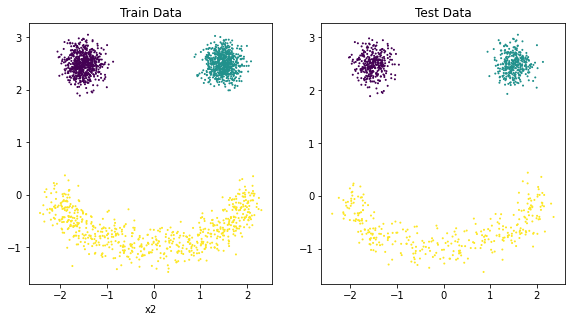

Dataset 2


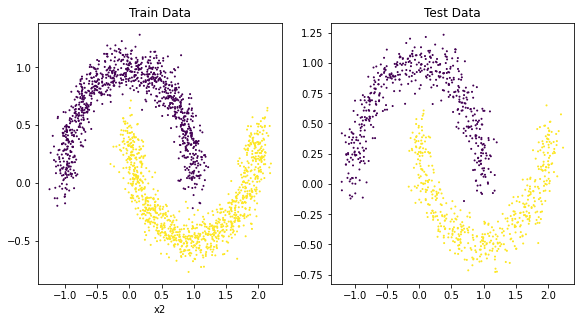

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Autoregressive Flow [15pt]

In an autoregressive flow, we learn the transformation $z_i = f(x_i ; x_{1:i-1})$. The log-likelihood is then $\log p_\theta(x) = \sum_{i=1}^d \log p(z_i) + \log |\frac{dz_i}{dx_i}|$ because the Jacobian is triangular. For each dimension, use the CDF of a mixture of Gaussians or Logistics to map to the latent space, which should be $z_i \sim \text{Unif}[0, 1]$ i.i.d..

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set. Since this is a 2D problem, you can either learn $z_0 = f(x_0)$ and $z_1 = f(x_1; x_0)$ together with a MADE model, or with separate networks. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Show a heatmap of the densities learned by your model
4. Show what the training set looks like when mapped to the latent space. 




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [3]:
from torch.optim import Adam

def train(model, train_loader, optimizer):
  model.train()
  train_losses = []
  for x in train_loader:
    x = x.cuda()
    optimizer.zero_grad()
    loss = model.nll(x)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def test(model, test_loader):
  model.eval()
  test_loss = torch.zeros(1).cuda()
  with torch.no_grad():
    for x in test_loader:
      x = x.long().cuda()
      test_loss += model.nll(x) * x.shape[0]
    avg_loss = test_loss / len(test_loader.dataset)
  return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
  lr = train_args['lr']
  epochs = train_args['epochs']
  optimizer = Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [test(model, test_loader)]
  for epoch in range(epochs):
    train_losses.extend(train(model, train_loader, optimizer))
    test_losses.append(test(model, test_loader))
  return train_losses, test_losses

In [ ]:
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import torch.nn as nn
import torch.nn.functional as F
import torch

class MixtureCDFFlow(nn.Module):
  def __init__(self,
               base_dist='uniform', 
               mixture_dist='gaussian',
               n_components=4):
    super().__init__()

    if base_dist == 'uniform':
        self.base_dist = Uniform(0.0, 1.0)
    else:
        raise NotImplementedError

    if mixture_dist == 'gaussian':
        self.mixture_dist = Normal
    elif mixture_dist == 'logistic':
        raise NotImplementedError

    self.n_components = n_components

    self.loc = nn.Parameter(torch.randn(n_components), requires_grad=True)
    self.log_scale = nn.Parameter(torch.zeros(n_components), requires_grad=True)
    self.weight_logits = nn.Parameter(torch.zeros(n_components), requires_grad=True)

  def flow(self, x):
    x_unsqueeze = x.unsqueeze(1).repeat(1, self.n_components)
    weights = F.softmax(self.weight_logits, dim=0).unsqueeze(0).repeat(x.shape[0], 1)
    z = (self.mixture_dist(self.loc, self.log_scale.exp()).cdf(x_unsqueeze) * weights).sum(dim=1)
    log_det = (self.mixture_dist(self.loc, self.log_scale.exp()).log_prob(x_unsqueeze).exp() * weights).sum(dim=1).log()
    return z, log_det

  def log_prob(self, x):
    z, log_det = self.flow(x)
    return self.base_dist.log_prob(z) + log_det

  def nll(self, x):
    return - self.log_prob(x).mean()

class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class AutoregressiveFlow(nn.Module):
  def __init__(self, 
               dim1_mixture_dist='gaussian', 
               dim1_n_components=5, 
               dim2_mixture_dist='gaussian', 
               dim2_n_components=5,
               mlp_hidden_size=64,
               mlp_n_layers=3):
    super().__init__()
    self.dim1_flow = MixtureCDFFlow(base_dist='uniform', mixture_dist=dim1_mixture_dist, n_components=dim1_n_components)
    self.mlp = MLP(1, mlp_n_layers, mlp_hidden_size, dim2_n_components * 3)

    self.dim2_n_components = dim2_n_components
    self.base_dist = Uniform(torch.tensor(0.0).cuda(), torch.tensor(1.0).cuda())
    if dim2_mixture_dist == 'gaussian':
        self.mixture_dist = Normal
    elif dim2_mixture_dist == 'logistic':
        raise NotImplementedError
    
  def flow(self, x):
    # individually flow on each dim
    x1, x2 = x[:,0], x[:,1]
    # dim 1 
    z1, log_det1 = self.dim1_flow.flow(x1)
    
    # dim 2
    loc, log_scale, weight_logits = torch.chunk(self.mlp(x1.unsqueeze(1)), 3, dim=1)
    # print(f"loc: {loc.shape}, log_scale: {log_scale.shape}, weight_logits: {weight_logits.shape}")
    weights = F.softmax(weight_logits, dim=1)

    x2_unsqueeze = x2.unsqueeze(1).repeat(1, self.dim2_n_components)
    z2 = (self.mixture_dist(loc, log_scale.exp()).cdf(x2_unsqueeze) * weights).sum(dim=1)
    # print(f"z1: {z1.min()}, {z1.max()}, z2: {z2.min()}, {z2.max()}")
    # print(f"z1: {z1.shape}, z2: {z2.shape}")
    log_det2 = (self.mixture_dist(loc, log_scale.exp()).log_prob(x2_unsqueeze).exp() * weights).sum(dim=1).log()
    # print(f"log_det1: {log_det1.shape}, log_det2: {log_det2.shape}")

    return torch.cat([z1.unsqueeze(1), z2.unsqueeze(1)], dim=1), torch.cat([log_det1.unsqueeze(1), log_det2.unsqueeze(1)], dim=1)

  def log_prob(self, x):
    z, log_det = self.flow(x)
    return (self.base_dist.log_prob(torch.clamp(z, min=0, max=1)) + log_det).mean(dim=1)

  def nll(self, x):
    return - self.log_prob(x.to(torch.float32)).mean()

In [ ]:
from torch.utils.data import DataLoader

def q1_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, dset_id: {dset_id}")

  # create data loaders
  train_loader =  DataLoader(train_data, batch_size=200, shuffle=True)
  test_loader =  DataLoader(train_data, batch_size=128)

  # model
  model = AutoregressiveFlow().cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {"epochs":100, "lr": 5e-3})

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).cuda()
  densities = np.exp((model.log_prob(mesh_xs).detach().cpu().numpy()))

  # latents
  z, _ = model.flow(torch.FloatTensor(train_data).cuda())
  latents = z.detach().cpu().numpy()

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



train_data: (1998, 2), test_data: (999, 2), dset_id: 1
Final Test Loss: 3.3341


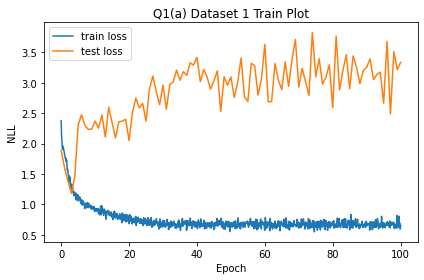

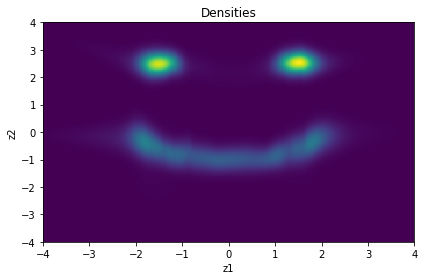

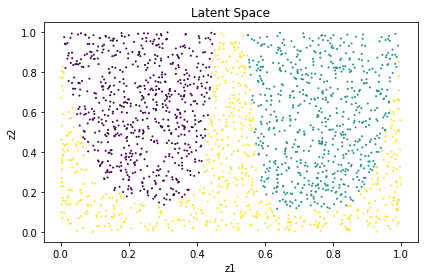

In [ ]:
q1_save_results(1, 'a', q1_a)

train_data: (2000, 2), test_data: (1000, 2), dset_id: 2
Final Test Loss: 0.7292


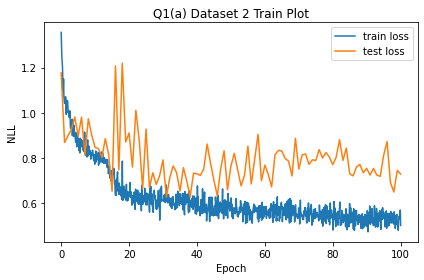

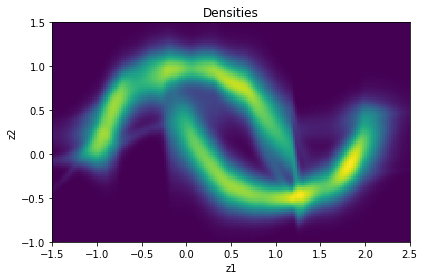

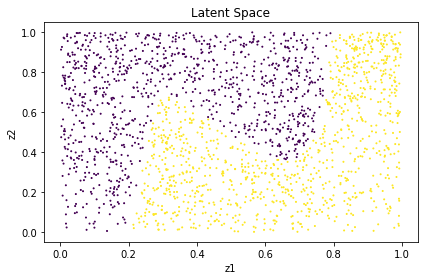

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) RealNVP [15pt]
In this part, we want to train a flow with the following structure: 
$(z_1, z_2) = (f_{\theta, 1} \circ \cdots \circ f_{\theta, n})$, 
where each $f_{\theta, i}$ is an affine transformation of 1 dimension, conditioned on the other, and $z \sim N(0, I)$. According to [Density Estimation Using Real NVP](https://arxiv.org/abs/1605.08803) Section 4.1, there's a particularly good way to parameterize the affine transformation:

Assuming that we're conditioning on $x_1$ and transforming $x_2$, we have 

- $z_1 = x_1$

- $ \text{log_scale} = \text{scale} \times tanh(g_{\theta, \text{scale}}(x_1)) + \text{scale_shift}$

- $z_2 = exp(\text{log_scale}) \times x_2 + g_{\theta, \text{shift}}(x_1)$

where $g_\theta$, $\text{scale}$, and $\text{scale_shift}$ are all learned parameters.


**Train a RealNVP model and provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
import torch.nn as nn
import torch

class AffineTransform(nn.Module):
    def __init__(self, type, n_hidden=2, hidden_size=256):
        super().__init__()
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = MLP(input_size=1, n_hidden=n_hidden, hidden_size=hidden_size, output_size=1)
        self.type = type

    def forward(self, x):
        # returns transform(x), log_det
        batch_size = x.shape[0]

        if self.type == "left":
          x1, x2 = x[:,0], x[:,1]
        elif self.type == "right":
          x1, x2 = x[:,1], x[:,0]

        z1 = x1
        g = self.mlp(x1.view(batch_size, 1)).squeeze()
        log_scale = (self.scale * torch.tanh(g)) + self.scale_shift
        z2 = torch.exp(log_scale) * x2 + g

        if self.type == "left":
          z = torch.column_stack((z1,z2))
        elif self.type == "right":
          z = torch.column_stack((z2,z1))

        return z, log_scale

class RealNVP(nn.Module):
    def __init__(self, transforms):
        super().__init__()

        self.prior = torch.distributions.Normal(torch.tensor(0.).cuda(), torch.tensor(1.).cuda())
        self.transforms = nn.ModuleList(transforms)
        
    def flow(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros(x.shape[0]).cuda()
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def log_prob(self, x):
        z, log_det = self.flow(x.float())
        return log_det + torch.sum(self.prior.log_prob(z), dim=1)

    def nll(self, x):
        return - self.log_prob(x).mean()

In [ ]:
from torch.utils.data import DataLoader

def q1_b(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in R^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}, dset_id: {dset_id}")

  # create data loaders
  train_loader =  DataLoader(train_data, batch_size=200, shuffle=True)
  test_loader =  DataLoader(train_data, batch_size=128)

  # model
  model = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64),
                    AffineTransform("left", n_hidden=2, hidden_size=64),
                    AffineTransform("right", n_hidden=2, hidden_size=64)]).cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader, test_loader, {"epochs":100, "lr": 5e-3})

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)]
  mesh_xs = torch.FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2)).cuda()
  densities = np.exp((model.log_prob(mesh_xs)).detach().cpu().numpy())

  # latents
  z, _ = model.flow(torch.FloatTensor(train_data).cuda())
  latents = z.detach().cpu().numpy()

  return train_losses, test_losses, densities, latents

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



train_data: (1998, 2), test_data: (999, 2), dset_id: 1
Final Test Loss: 7.2663


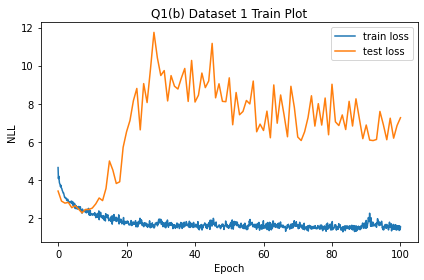

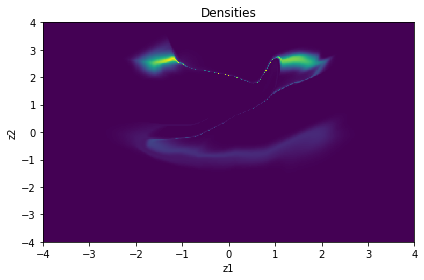

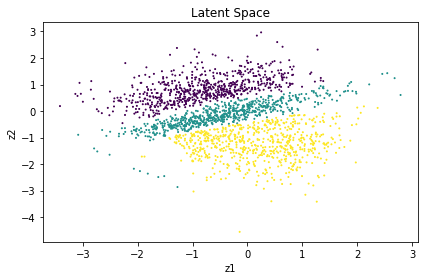

In [ ]:
q1_save_results(1, 'b', q1_b)

train_data: (2000, 2), test_data: (1000, 2), dset_id: 2
Final Test Loss: 1.1923


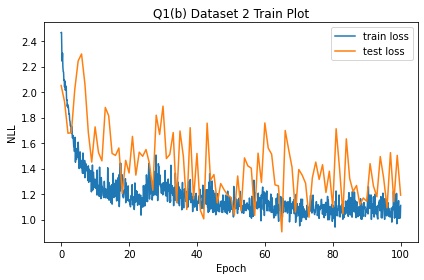

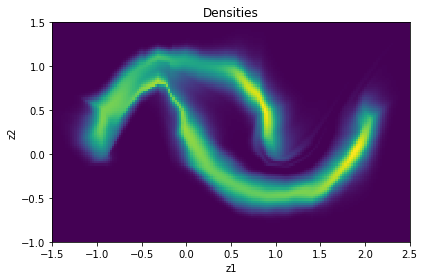

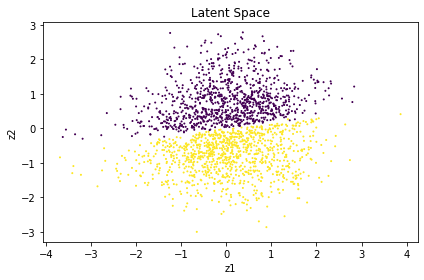

In [ ]:
q1_save_results(2, 'b', q1_b)

# Question 2: Autoregressive Flows for Images [20pt]
We can scale up the autoregressive flows from 1(a) to high-dimensional image data. In this question, we will focus on the black-and-white shapes dataset from Homework 1.

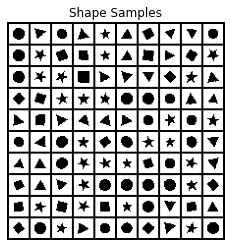

In [ ]:
visualize_q2_data()

Adapt your PixelCNN implementation from Homework 1 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 1 3(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [15]:
from torch.optim import Adam
from tqdm import trange, tqdm_notebook

def train_with_dequantization_q2(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = torch.as_tensor(x).float().contiguous().cuda()
        x += torch.distributions.Uniform(0.0, 0.5).sample(x.shape).cuda()
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def train_epochs_q2(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [test(model, test_loader)]
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        epoch_train_losses = train_with_dequantization_q2(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_losses.append(test(model, test_loader))
    return train_losses, test_losses

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

class MaskConv2d(nn.Conv2d):
  def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
    assert mask_type == 'A' or mask_type == 'B'
    super().__init__(in_channels, out_channels, kernel_size, padding=padding)
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    self.mask[:, :, :k // 2] = 1
    self.mask[:, :, k // 2, :k // 2] = 1
    if mask_type == 'B':
      self.mask[:, :, k // 2, k // 2] = 1

  def forward(self, input, cond=None):
    batch_size = input.shape[0]
    out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    return out

class ResBlock(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    self.block = nn.Sequential(
        nn.ReLU(),
        MaskConv2d('B', in_channels, in_channels//2, 1),
        nn.ReLU(),
        MaskConv2d('B', in_channels//2, in_channels//2, 7, padding=7//2),
        nn.ReLU(),
        MaskConv2d('B', in_channels// 2, in_channels, 1)
    )

  def forward(self, x):
    return self.block(x) + x

class LayerNorm(nn.LayerNorm):
  def __init__(self, n_filters):
    super().__init__(n_filters)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x = super().forward(x)
    return x.permute(0, 3, 1, 2).contiguous()

class AutoregressiveFlowPixelCNN(nn.Module):
  def __init__(self, input_shape, n_components=2, n_filters=64, kernel_size=7, n_layers=5, use_resblock=False) :
    super().__init__()
    assert n_layers >= 2
    n_channels = input_shape[0]
    
    self.input_shape = input_shape
    self.n_components = n_components
    self.n_channels = n_channels

    module_list = [MaskConv2d('A', n_channels, n_filters, kernel_size, padding=kernel_size // 2)]

    if use_resblock:
      block_init = lambda: ResBlock(n_filters)
    else:    
      block_init = lambda: MaskConv2d('B', n_filters, n_filters, kernel_size, padding=kernel_size // 2)

    for _ in range(n_layers):
      module_list.append(LayerNorm(n_filters))
      module_list.extend([nn.ReLU(), block_init()])

    module_list.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1)])
    module_list.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_channels * 3 * self.n_components, 1)])

    self.net = nn.Sequential(*module_list)
    self.base_dist = Uniform(torch.tensor(0.0).cuda(), torch.tensor(1.0).cuda())

  def forward(self, x):
    batch_size = x.shape[0]
    return self.net(x.float()).view(batch_size, 3 * self.n_components, *self.input_shape)

  def flow(self, x):
    x_unsqueeze = x.unsqueeze(1).repeat(1, 1, self.n_components, 1 ,1)
    loc, log_scale, weight_logits = torch.chunk(self(x), 3, dim=1)
    weights = F.softmax(weight_logits, dim=1)
    z = (Normal(loc, log_scale.exp()).cdf(x_unsqueeze) * weights).sum(dim=1)
    log_det = (Normal(loc, log_scale.exp()).log_prob(x_unsqueeze).exp() * weights).sum(dim=1).log()
    return z, log_det

  def log_prob(self, x):
    z, log_det = self.flow(x)
    return self.base_dist.log_prob(torch.clamp(z, min=0, max=1)) + log_det

  def nll(self, x):
    return - self.log_prob(x).mean()

  def sample(self, n, cond=None):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            loc, log_scale, weight_logits = torch.chunk(self.forward(samples), 3, dim=1)
            loc, log_scale, weight_logits = loc[:,:,k,r,c], log_scale[:,:,k,r,c], weight_logits[:,:,k,r,c]
            probs = F.softmax(weight_logits, dim=1)
            chosen_centers = torch.multinomial(probs, 1).squeeze(-1)
            samples[:, k, r, c] = torch.normal(loc[torch.arange(n), chosen_centers], log_scale[torch.arange(n), chosen_centers].exp())
    return samples.permute(0, 2, 3, 1).cpu().numpy()

In [17]:
from torch.utils.data import DataLoader

def q2(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  """ YOUR CODE HERE """
  H, W = 20, 20
  train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
  test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)
  print(f"train_data: {train_data.shape}, test_data: {test_data.shape}")

  # create data loaders
  train_loader =  DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader =  DataLoader(train_data, batch_size=128)

  # model
  model = AutoregressiveFlowPixelCNN((1, H, W), n_layers=5, n_components=10).cuda()

  # train
  train_losses, test_losses = train_epochs_q2(model, train_loader, test_loader, {"epochs":20, "lr": 5e-3})

  samples = model.sample(100)
  return train_losses + np.log(2), test_losses + np.log(2), samples

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



train_data: (10479, 1, 20, 20), test_data: (4491, 1, 20, 20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Final Test Loss: 1.1091


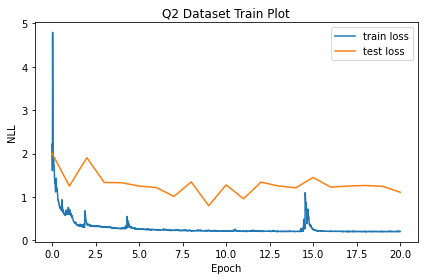

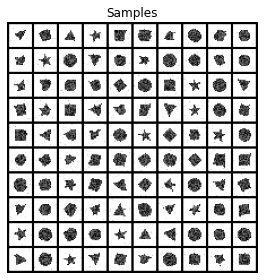

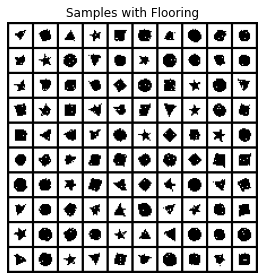

In [18]:
q2_save_results(q2)

# Question 3: RealNVP on Higher Dimensions


In this problem, you will train a flow model to invertibly map a high dimensional dataset of celebrity
faces to gaussian noise. The dataset is a low-resolution (32 × 32) version of the CelebA-HQ dataset that has been quantized to 2 bits per color channel.



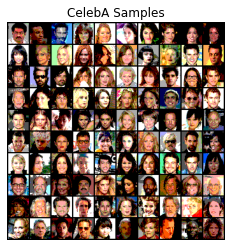

In [ ]:
visualize_q3_data()

## Part (a): RealNVP [40pt]

Use the affine coupling flow from RealNVP and a form of [data-dependent initialization](https://arxiv.org/abs/1602.07868) that normalizes activations from an initial forward pass with a minibatch.
We describe a reference architecture below that can achieve good performance, but you are free
and encouraged to use different architectures and/or structure your code differently.



```
Preprocess() # dequantization, logit trick from RealNVP (Dinh et al) Section 4.1

for _ in range(4):
  AffineCouplingWithCheckerboard() # Figure 3 in Dinh et al - (left)
  ActNorm() # described in Glow (Kingma & Dhariwal) Section 3.1
Squeeze(), # [b, c, h, w] --> [b, c*4, h//2, w//2]

for _ in range(3):
  AffineCouplingWithChannel()
  ActNorm()
Unsqueeze(), # [b, c*4, h//2, w//2] --> [b, c, h, w]

for _ in range(3):
  AffineCouplingWithCheckerboard()
  ActNorm()
```



Here, we provide pseudocode for the basic structure of each coupling layer. 



```
# pseudocode
ResnetBlock: n_filters
  h = x
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (3,3), stride=1, padding=1)(h)
  h = relu(h)
  h = conv2d(n_filters, n_filters, (1,1), stride=1, padding=0)(h)
  return h + x

SimpleResnet: n_filters = 128, n_blocks = 8, n_out
  conv2d(in_channels, n_filters=n_filters, (3,3), stride=1, padding=1)
  apply 8 ResnetBlocks with n_filters=n_filters
  relu()
  conv2d(in_channels=n_filters, out_channels=n_out, (3,3), stride=1, padding=1)
  
AffineCoupling(x, mask):
  x_ = x * mask
  log_s, t = torch.chunk(SimpleResnet(x_), 2, dim=1)
  # calculate log_scale, as done in Q1(b)
  t = t * (1.0 - mask)
  log_scale = log_scale * (1.0 - mask)
  z = x * torch.exp(log_scale) + t
  log_det_jacobian = log_scale
  return z, log_det_jacobian
```



We use an Adam Optimizer with a warmup over 200 steps till a learning rate of 5e-4. We didn’t decay the learning rate but it is a generally recommended practice while training generative models. We show samples from our model at the end of training, as well as interpolations between several images in our dataset.  Our reference solution achieves a test loss of about 0.55 bits/dim after 100 epochs. 



**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model
4. 5 rows of interpolations between images in the test set; each row consists of the start and end images, and 4 intermediate ones. You should return 30 total images. 



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



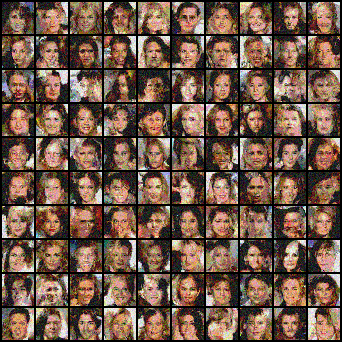

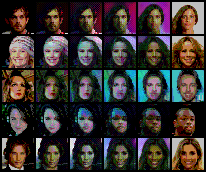

In [ ]:
q3_save_results(q3_a, 'a')

## Part (b): Exploring bad masking schemes [10pt]

As shown in lecture, the choice of masking or partitioning scheme affects the quality of the final flow model. In this part, design a *bad* masking scheme and train a model with it on the same CelebA dataset. 

**Provide the same deliverables as part (a)**

In [ ]:
def q3_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

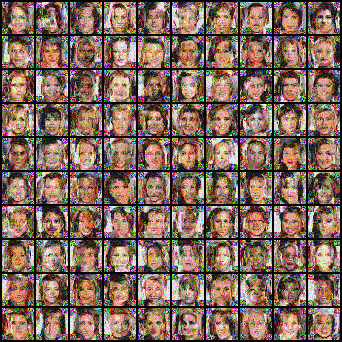

In [ ]:
q3_save_results(q3_b, 'b')

# Question 4: Bonus Questions (Optional)

## Q4(a): Multiscale RealNVP [10pt]
Following the alternating checkerboard, channel squeeze, and channel partition scheme used in https://arxiv.org/abs/1605.08803, learn a multiscale RealNVP model on our CelebA dataset used in Question 3. We expect the same deliverables as in Question 3; additionally, make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_a(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_a, 'bonus_a')

## Q4(b): Glow [5pt]
The Glow paper introduces the invertible 1x1 convolution as a replacement for the permutation scheme that follows the channel squeezing step. Use this in your model from Question 3, and report the same deliverables. Make sure to include analysis on any difference in qualitative or quantitative differences you see in the results.

In [ ]:
def q4_b(train_data, test_data):
  """
  train_data: A (n_train, H, W, 3) uint8 numpy array of quantized images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, 3) uint8 numpy array of binary images with values in {0, 1, 2, 3}

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 3) of samples with values in [0, 1]
  - a numpy array of size (30, H, W, 3) of interpolations with values in [0, 1].
  """
  
  """ YOUR CODE HERE """

In [ ]:
q3_save_results(q4_b, 'bonus_b')

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)